<a href="https://colab.research.google.com/github/mimomaina/machine-learning_002/blob/main/Airquality_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
pip install liac-arff


  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=f60fc021fbceffbb65c20b6f32943a6bee11f470fd9d669ac470fb84aa19f0e8
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [ ]:
pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arff
from category_encoders import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


# Load Dataset

In [ ]:
# Load the ARFF file
with open('/content/air_dataset.arff', 'r') as f:
    dataset = arff.load(f)

# Convert to a pandas DataFrame
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])
print(df.head())


   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  


# Data Cleaning and Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


PM2.5:This is a key indicator of air quality and is harmful due to its ability to penetrate deep into the lungs.

PM10:Important for measuring larger airborne particles that also affect air quality.

SO2:Indicates pollution from industrial activities, fossil fuels, etc.

NO2:Typically produced by traffic and industrial emissions; affects air quality and health.

CO:Often produced by incomplete combustion; a crucial pollutant for analysis.

O3:Ozone concentration.

wd: wind direction

In [ ]:
#display the percentage of missing values for each column
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)

No         0.000000
year       0.000000
month      0.000000
day        0.000000
hour       0.000000
PM2.5      2.076916
PM10       1.532674
SO2        2.143937
NO2        2.879497
CO         4.919813
O3         3.155421
TEMP       0.094589
PRES       0.093401
DEWP       0.095777
RAIN       0.092688
wd         0.433018
WSPM       0.075576
station    0.000000
dtype: float64


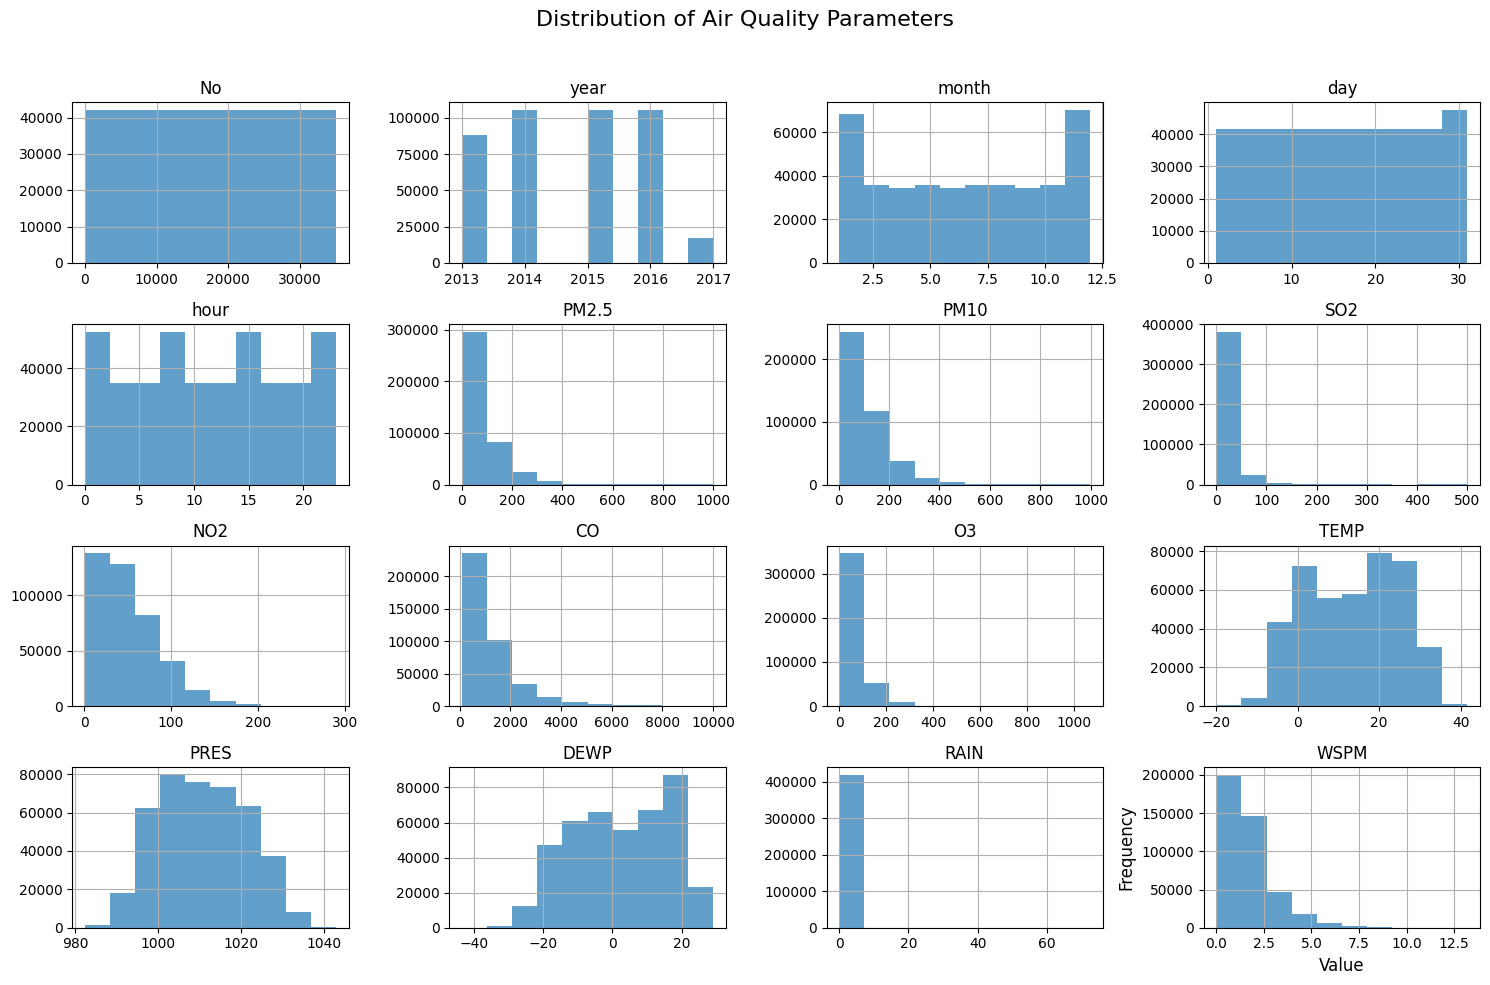

In [ ]:
df.hist(bins=10, figsize=(15,10), alpha=0.7)

plt.suptitle('Distribution of Air Quality Parameters', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

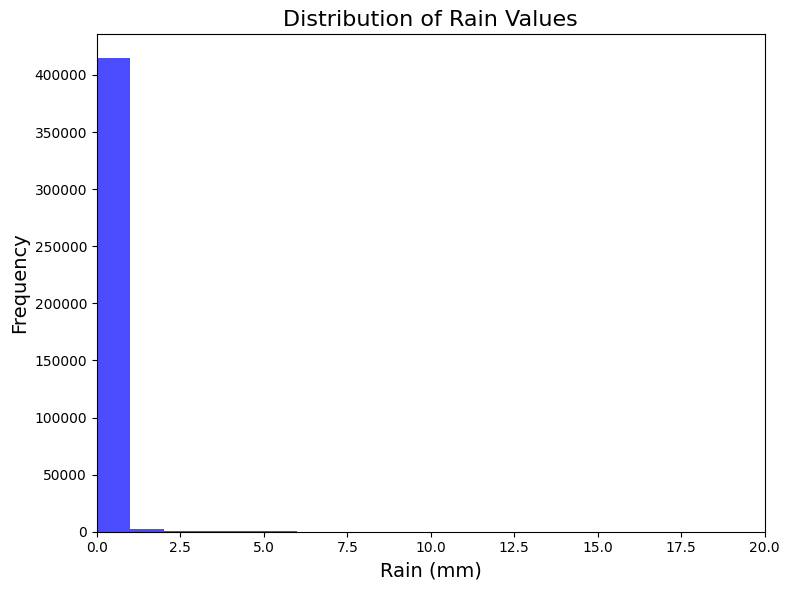

In [ ]:
# Plot histogram for the 'Rain' column
plt.figure(figsize=(8, 6))
plt.hist(df['RAIN'], bins=20, range=(0, 20), alpha=0.7, color='blue')

plt.title('Distribution of Rain Values', fontsize=16)
plt.xlabel('Rain (mm)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 20)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#median_rain
median_rain = df['RAIN'].median()
print(median_rain)
#fill missing values with median
df['RAIN'].fillna(median_rain, inplace=True)

0.0


<ipython-input-11-690e1b0ea890>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RAIN'].fillna(median_rain, inplace=True)


In [ ]:
#median_wspm
median_wspm = df['WSPM'].median()
print(median_wspm)
#fill missing values with median
df['WSPM'].fillna(median_wspm, inplace=True)

1.4


<ipython-input-12-b778527cf887>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['WSPM'].fillna(median_wspm, inplace=True)


In [ ]:
#mean_dewp
mean_dewp = df['DEWP'].mean()
print(mean_dewp)
#fill missing values with mean
df['DEWP'].fillna(mean_dewp, inplace=True)

2.490822023717484


<ipython-input-13-f477f0f31275>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DEWP'].fillna(mean_dewp, inplace=True)


In [ ]:
#mean_pres
mean_pres = df['PRES'].mean()
print(mean_pres)
#fill missing values with mean
df['PRES'].fillna(mean_pres, inplace=True)

1010.7469819844983


<ipython-input-14-c0d9db57ead2>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PRES'].fillna(mean_pres, inplace=True)


In [ ]:
#mean_temp
mean_temp = df['TEMP'].mean()
print(mean_temp)
#fill missing values with mean
df['TEMP'].fillna(mean_temp, inplace=True)

13.538975833816355


<ipython-input-15-7c64ecc84860>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TEMP'].fillna(mean_temp, inplace=True)


In [ ]:
#median_o3
median_o3 = df['O3'].median()
print(median_o3)
#fill missing values with median
df['O3'].fillna(median_o3, inplace=True)

45.0


<ipython-input-16-5914ac5faf43>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['O3'].fillna(median_o3, inplace=True)


In [ ]:
#median_co
median_co = df['CO'].median()
print(median_co)
#fill missing values with median
df['CO'].fillna(median_co, inplace=True)

900.0


<ipython-input-17-b251e79bc05c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CO'].fillna(median_co, inplace=True)


In [ ]:
#median_no2
median_no2 = df['NO2'].median()
print(median_no2)
#fill missing values with median
df['NO2'].fillna(median_no2, inplace=True)

43.0


<ipython-input-18-21fa5bbc0bf2>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['NO2'].fillna(median_no2, inplace=True)


In [ ]:
#median_so2
median_so2 = df['SO2'].median()
print(median_so2)
#fill missing values with median
df['SO2'].fillna(median_so2, inplace=True)

7.0


<ipython-input-19-0c1c5b16cb45>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SO2'].fillna(median_so2, inplace=True)


In [ ]:
#median_pm10
median_pm10 = df['PM10'].median()
print(median_pm10)
#fill missing values with median
df['PM10'].fillna(median_pm10, inplace=True)

82.0


<ipython-input-20-7529de994bf2>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PM10'].fillna(median_pm10, inplace=True)


In [ ]:
#median_PM2.5
median_pm25 = df['PM2.5'].median()
print(median_pm25)
#fill missing values with median
df['PM2.5'].fillna(median_pm25, inplace=True)


55.0


<ipython-input-21-a37476701458>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PM2.5'].fillna(median_pm25, inplace=True)


In [ ]:
#check for unique values in wd
df['wd'].unique()

array(['NNW', 'N', 'NW', 'NNE', 'ENE', 'E', 'NE', 'W', 'SSW', 'WSW', 'SE',
       'WNW', 'SSE', 'ESE', 'S', 'SW', None], dtype=object)

In [ ]:
#wd_mode
wd_mode = df['wd'].mode()[0]
print(wd_mode)
#fill missing values with mode
df['wd'].fillna(wd_mode, inplace=True)

NE


<ipython-input-23-1554daa0203a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wd'].fillna(wd_mode, inplace=True)


In [ ]:
#percentage missingness in the columns
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)

No         0.0
year       0.0
month      0.0
day        0.0
hour       0.0
PM2.5      0.0
PM10       0.0
SO2        0.0
NO2        0.0
CO         0.0
O3         0.0
TEMP       0.0
PRES       0.0
DEWP       0.0
RAIN       0.0
wd         0.0
WSPM       0.0
station    0.0
dtype: float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    420768 non-null  float64
 6   PM10     420768 non-null  float64
 7   SO2      420768 non-null  float64
 8   NO2      420768 non-null  float64
 9   CO       420768 non-null  float64
 10  O3       420768 non-null  float64
 11  TEMP     420768 non-null  float64
 12  PRES     420768 non-null  float64
 13  DEWP     420768 non-null  float64
 14  RAIN     420768 non-null  float64
 15  wd       420768 non-null  object 
 16  WSPM     420768 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


# Feature Engineering

# **1.Encoding**

In [ ]:
lags = [1, 2, 3, 24]
for lag in lags:
    df[f'PM2.5_lag{lag}'] = df['PM2.5'].shift(lag)

In [ ]:
# 2. Rolling Features
df['PM2.5_rolling_mean'] = df['PM2.5'].rolling(window=3).mean()
df['rolling_std_3'] = df['PM2.5'].rolling(window=3).std()

In [ ]:
# 3. Time-Based Features
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour


In [ ]:
binary_encoder = BinaryEncoder()
encoded_data = binary_encoder.fit_transform(df[['wd', 'station']])
df = pd.concat([df, encoded_data], axis=1)


In [ ]:
df.drop(['wd', 'station'], axis=1, inplace=True)

# **2. Feature scaling**

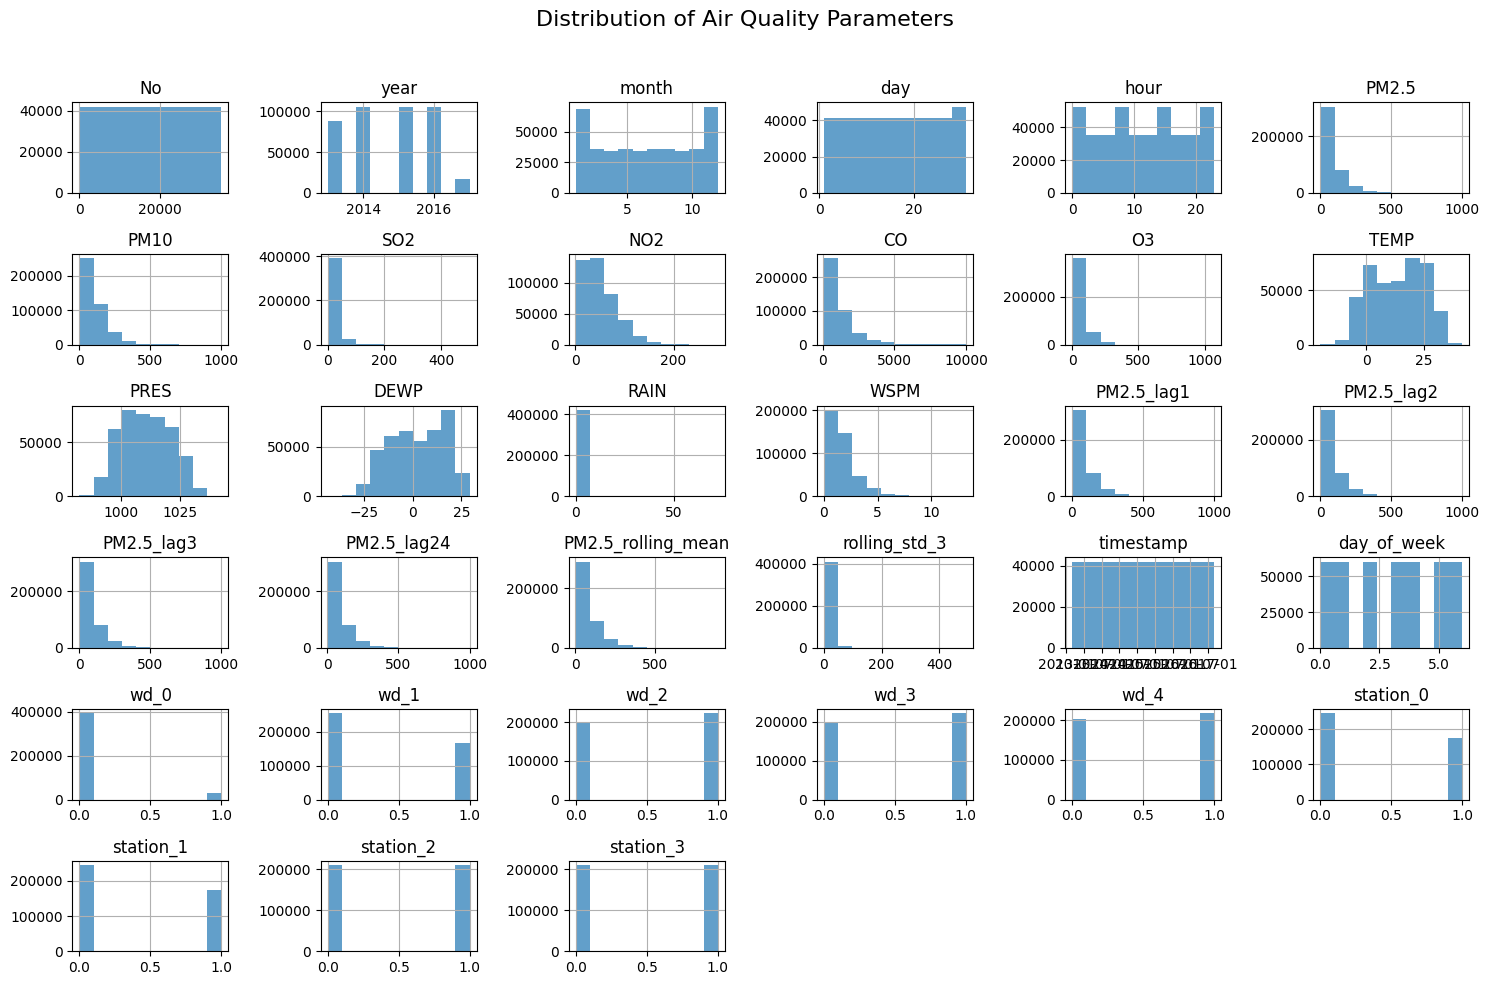

In [ ]:
df.hist(bins=10, figsize=(15,10), alpha=0.7)

plt.suptitle('Distribution of Air Quality Parameters', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
normal_columns = ['TEMP','PRES','DEWP']
scaler_standard = StandardScaler()
df[normal_columns] = scaler_standard.fit_transform(df[normal_columns])

In [ ]:
selected_columns = ['RAIN','WSPM','PM2.5','PM10','SO2','NO2','CO','O3','No']
scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])



# Training and Modelling



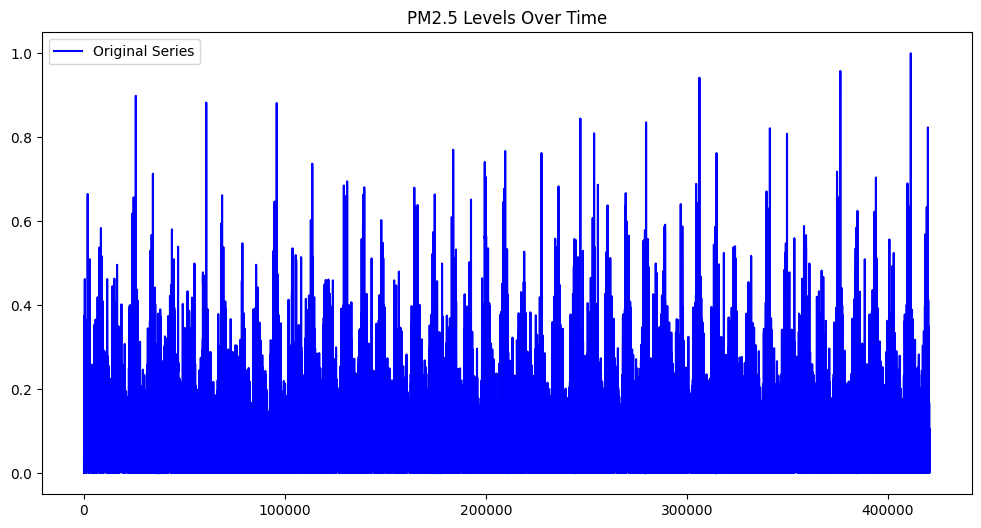

In [ ]:
# Plot original series
plt.figure(figsize=(12, 6))
plt.plot(df['PM2.5'], label='Original Series', color='blue')
plt.title('PM2.5 Levels Over Time')
plt.legend()
plt.show()




In [ ]:
# Rolling mean and standard deviation
rolling_mean = df['PM2.5'].rolling(window=24).mean()
rolling_std = df['PM2.5'].rolling(window=24).std()

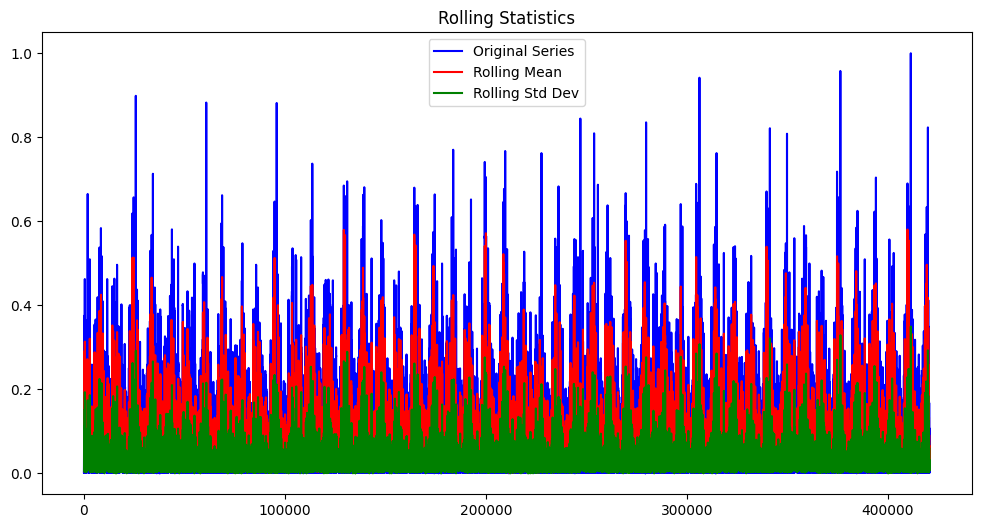

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['PM2.5'], label='Original Series', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.title('Rolling Statistics')
plt.legend()
plt.show()

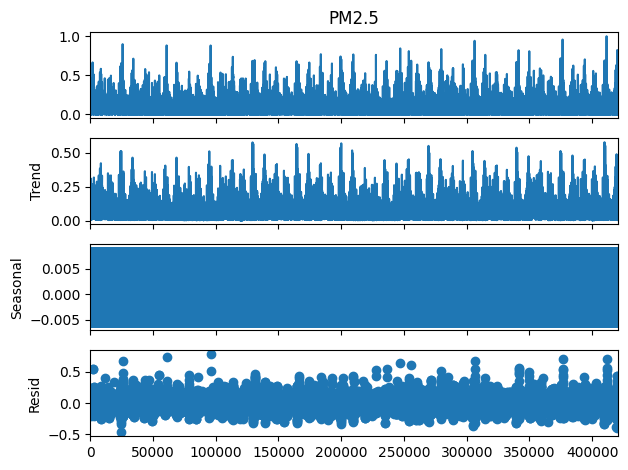

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(df['PM2.5'].dropna(), model='additive', period=24)
decomposition.plot()
plt.show()

<Figure size 1000x600 with 0 Axes>

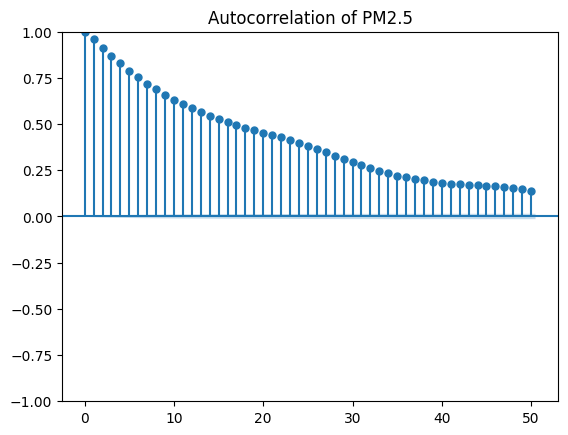

In [ ]:
target_series = df['PM2.5']

# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(target_series, lags=50, title='Autocorrelation of PM2.5')
plt.show()



<Figure size 1000x600 with 0 Axes>

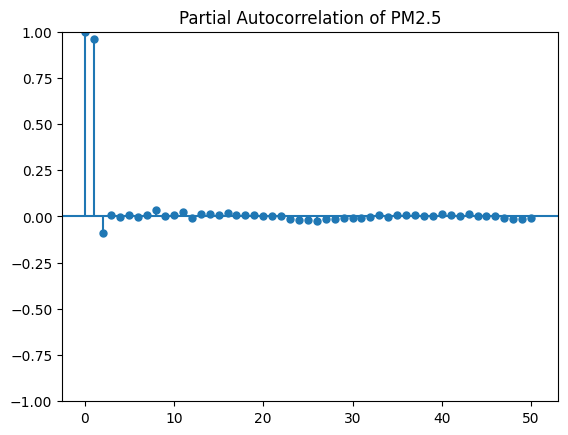

In [ ]:
# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(target_series, lags=50, title='Partial Autocorrelation of PM2.5')
plt.show()

In [ ]:
train_size = int(0.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [ ]:
# Fit ARIMA model
model = ARIMA(df['PM2.5'].dropna(), order=(2, 2, 0))
model_fit = model.fit()

In [ ]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:               420768
Model:                 ARIMA(2, 2, 0)   Log Likelihood              934050.365
Date:                Thu, 16 Jan 2025   AIC                       -1868094.730
Time:                        05:59:02   BIC                       -1868061.881
Sample:                             0   HQIC                      -1868085.364
                             - 420768                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5930      0.000  -2102.163      0.000      -0.594      -0.592
ar.L2         -0.3183      0.000   -853.872      0.000      -0.319      -0.318
sigma2         0.0007   2.46e-07   2802.868      0.0

In [ ]:
# Forecast the next 24 periods
forecast = model_fit.forecast(steps=24)
print("Forecasted Values:")
print(forecast)

Forecasted Values:
420768    0.011209
420769    0.010918
420770    0.011167
420771    0.011245
420772    0.011252
420773    0.011356
420774    0.011425
420775    0.011483
420776    0.011559
420777    0.011628
420778    0.011696
420779    0.011766
420780    0.011836
420781    0.011905
420782    0.011974
420783    0.012044
420784    0.012113
420785    0.012182
420786    0.012252
420787    0.012321
420788    0.012391
420789    0.012460
420790    0.012529
420791    0.012599
Name: predicted_mean, dtype: float64


# Model Evaluation and Visualization

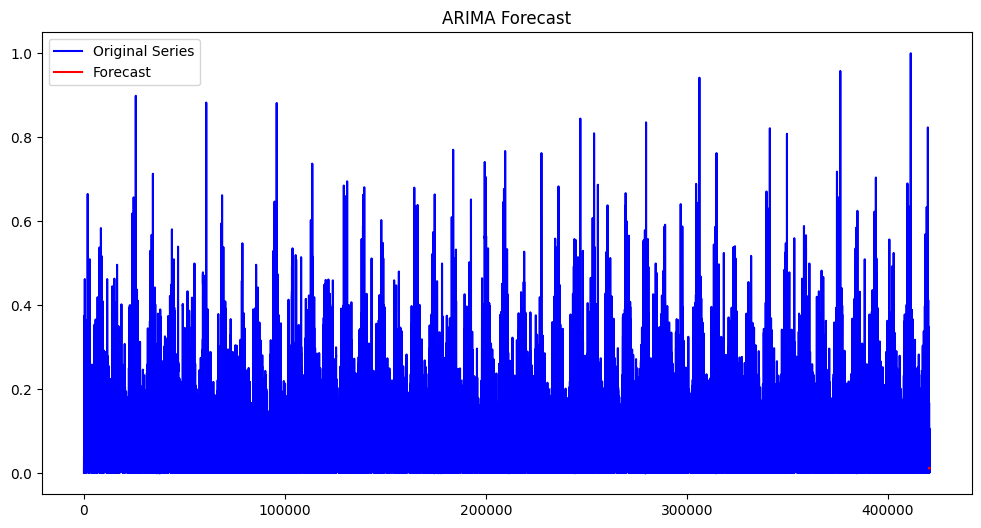

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['PM2.5'].dropna(), label='Original Series', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()
